In [1]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
import emoji
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peloton.  All were held on the same course but the road races include two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx("files/Calga_RR_2016.gpx")
tt_2016 = parse_gpx("files/Calga_TT_2016.gpx")
rr_2019 = parse_gpx("files/Calga_RR_2019.gpx")
tt_2019 = parse_gpx("files/Calga_TT_2019.gpx")


In [3]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


In [4]:
tt_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,0.0,58.0,108.0,0.000000,0.0,0.000000,NaN
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,0.0,58.0,105.0,0.006161,0.0,11.089134,2.0
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,0.0,58.0,105.0,0.001652,0.0,0.991282,6.0
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,0.0,58.0,100.0,0.001595,0.0,0.249655,23.0
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,0.0,65.0,101.0,0.001595,0.0,5.742071,1.0


## 1. What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.


In [5]:
# D for Distance

D_rr_2016 = sum(rr_2016.distance)
D_tt_2016 = sum(tt_2016.distance)
D_rr_2019 = sum(rr_2019.distance)
D_tt_2019 = sum(tt_2019.distance)

# T for Time
T_rr_2016 = sum(rr_2016.timedelta.dropna()) / 60
T_tt_2016 = sum(tt_2016.timedelta.dropna()) / 60
T_rr_2019 = sum(rr_2019.timedelta.dropna()) / 60
T_tt_2019 = sum(tt_2019.timedelta.dropna()) / 60

# Calc Average Speed
def spd(d, t):
    return round(d / (t / 60), 2)


print("2016 Road Race")
print("Distance:", round(D_rr_2016, 2), "kms")
print("Time:", round(T_rr_2016, 2), "minutes")
print("Average Speed:", spd(D_rr_2016, T_rr_2016), "km/h")
print("\n")
print("2016 Time Trial")
print("Distance:", round(D_tt_2016, 2), "kms")
print("Time:", round(T_tt_2016, 2), "minutes")
print("Average Speed:", spd(D_tt_2016, T_tt_2016), "km/h")
print("\n")
print("2019 Road Race")
print("Distance:", round(D_rr_2019, 2), "kms")
print("Time:", round(T_rr_2019, 2), "minutes")
print("Average Speed:", spd(D_rr_2019, T_rr_2019), "km/h")
print("\n")
print("2019 Time Trial")
print("Distance:", round(D_tt_2019, 2), "kms")
print("Time:", round(T_tt_2019, 2), "minutes")
print("Average Speed:", spd(D_tt_2019, T_tt_2019), "km/h")
print("\n")
print(
    emoji.emojize(
        "I have to say steve is quite fit, coz my average speed for riding around West Ryde is only 12km/h :grinning_squinting_face:"
    )
)


2016 Road Race
Distance: 49.05 kms
Time: 86.67 minutes
Average Speed: 33.96 km/h


2016 Time Trial
Distance: 24.8 kms
Time: 45.78 minutes
Average Speed: 32.5 km/h


2019 Road Race
Distance: 51.79 kms
Time: 91.7 minutes
Average Speed: 33.89 km/h


2019 Time Trial
Distance: 24.38 kms
Time: 44.23 minutes
Average Speed: 33.07 km/h


I have to say steve is quite fit, coz my average speed for riding around West Ryde is only 12km/h 😆


## 2. Compare the range of speeds for each ride, are time trials faster than road races? 


In [6]:
rr_2016["smoothed"] = rr_2016["speed"].rolling(10, min_periods=1).mean()
rr_2016["time"] = 0
for i in range(1, len(rr_2016)):
    rr_2016.iat[i, 12] = rr_2016.iloc[i - 1]["time"] + rr_2016.iloc[i]["timedelta"]

tt_2016["smoothed"] = tt_2016["speed"].rolling(10, min_periods=1).mean()
tt_2016["time"] = 0
for i in range(1, len(tt_2016)):
    tt_2016.iat[i, 12] = tt_2016.iloc[i - 1]["time"] + tt_2016.iloc[i]["timedelta"]


In [7]:
rr_2019["smoothed"] = rr_2019["speed"].rolling(10, min_periods=1).mean()
rr_2019["time"] = 0
for i in range(1, len(rr_2019)):
    rr_2019.iat[i, 12] = rr_2019.iloc[i - 1]["time"] + rr_2019.iloc[i]["timedelta"]

tt_2019["smoothed"] = tt_2019["speed"].rolling(10, min_periods=1).mean()
tt_2019["time"] = 0
for i in range(1, len(tt_2019)):
    tt_2019.iat[i, 12] = tt_2019.iloc[i - 1]["time"] + tt_2019.iloc[i]["timedelta"]


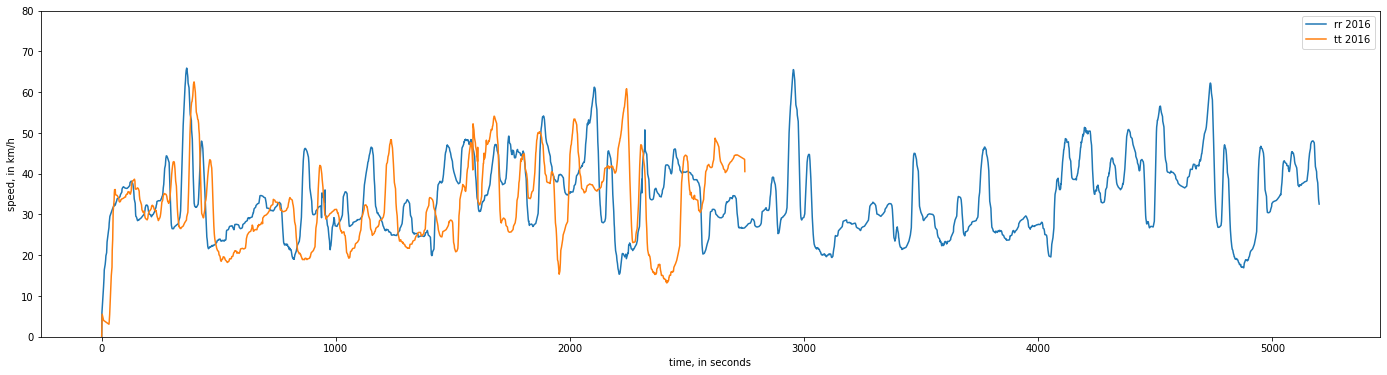

In [8]:
plt.figure(figsize=(24, 6))
plt.ylim(0, 80)
plt.plot(rr_2016.time, rr_2016.smoothed, label="rr 2016")
plt.plot(tt_2016.time, tt_2016.smoothed, label="tt 2016")
plt.xlabel("time, in seconds")
plt.ylabel("speed, in km/h")
plt.legend()
None


Comparing the two lines of 2016 races, it seems that Steve's time trial speed is mostly consistent with his roadrace, but we can see that the time trial's peaks and valleys are further away from those of road race's, which means he's actually slower in time trials.

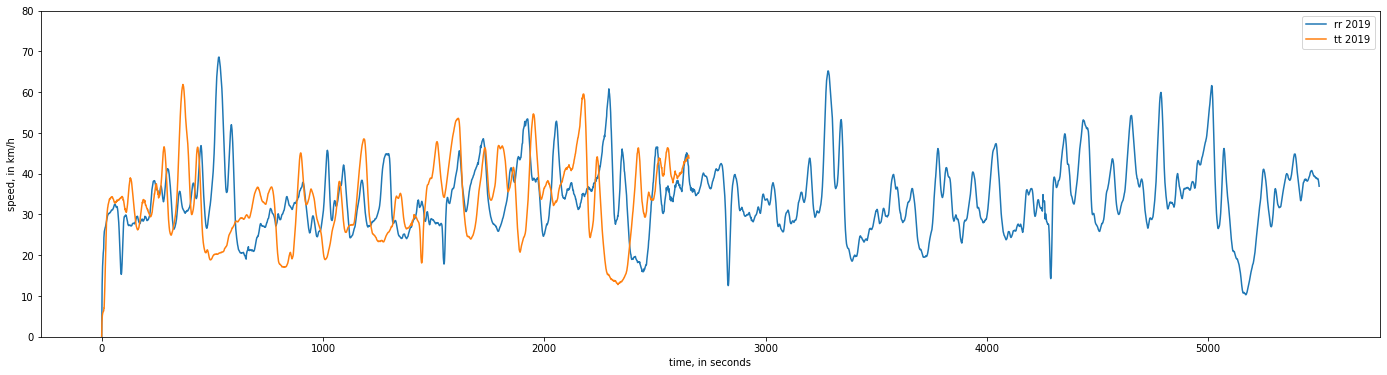

In [9]:
plt.figure(figsize=(24, 6))
plt.ylim(0, 80)
plt.plot(rr_2019.time, rr_2019.smoothed, label="rr 2019")
plt.plot(tt_2019.time, tt_2019.smoothed, label="tt 2019")
plt.xlabel("time, in seconds")
plt.ylabel("speed, in km/h")
plt.legend()
None


Comparing the two lines of 2019 races, it seems that Steve's time trial peaks and valleys are further away from those of road race's, which means he's actually faster in time trial.

## 3. Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  


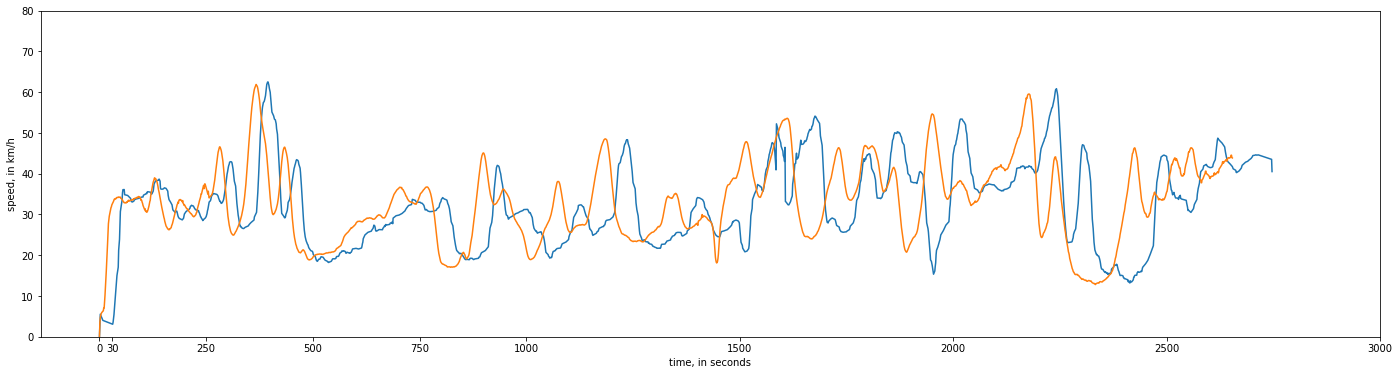

In [10]:
plt.figure(figsize=(24, 6))
plt.ylim(0, 80)
plt.plot(tt_2016.time, tt_2016.smoothed, label="tt 2016")
plt.plot(tt_2019.time, tt_2019.smoothed, label="tt 2019")
plt.xlabel("time, in seconds")
plt.ylabel("speed, in km/h")
plt.xticks(ticks=(0, 30, 250, 500, 750, 1000, 1500, 2000, 2500, 3000))
None

Steve did better in 2019, because he finished earlier. And in 2016, apparently there was a problem around 30s in, his speed dropped suddenly. Fortunately He didn't have the same problem in 2019. Also his performace in 2019 became better coz the peaks and valleys leade further than those of 2016's.


## 4. From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls. 

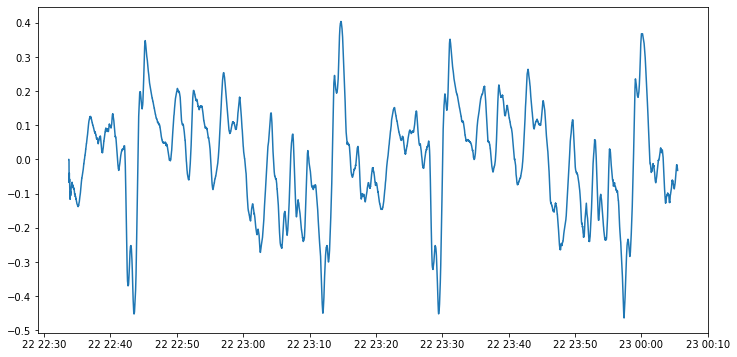

In [11]:
import matplotlib.ticker as plticker

rr19 = rr_2019[['elevation_gain','distance','timedelta']]
rr19['rolled'] = rr19['elevation_gain'].rolling(100, min_periods=1).mean() # to see it better
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(rr19.index,rr19['rolled'])
loc = plticker.MultipleLocator(base=0.1)
ax.yaxis.set_major_locator(loc)
rr19.drop('rolled',axis=1,inplace=True)


In [12]:
rr19.head()

,elevation_gain,distance,timedelta
2019-06-22 22:33:45+00:00,0.0,0.000000,NaN
2019-06-22 22:33:46+00:00,0.0,0.004679,1.0
2019-06-22 22:33:47+00:00,-0.2,0.005936,1.0
2019-06-22 22:33:48+00:00,0.0,0.006599,1.0
2019-06-22 22:33:49+00:00,0.0,0.006729,1.0


In [13]:
# >0.1 as climbing, <-0.1 as decending, flat in between

climb = rr19[rr19.elevation_gain >= 0.1]
print(climb.shape)
print("average climbing speed for rr 2019 (km/h):")
climb["distance"].sum() / climb["timedelta"].sum() * 3600


(2361, 3)
average climbing speed for rr 2019 (km/h):


28.815088872958746

In [14]:
flat = rr19[(rr19.elevation_gain>=-0.1) & (rr19.elevation_gain<=0.1)]
print(flat.shape)
print('average flat speed for rr 2019 (km/h):')
flat['distance'].sum()/flat['timedelta'].sum() * 3600

(1419, 3)
average flat speed for rr 2019 (km/h):


33.48205811120751

In [15]:
descend = rr19[rr19.elevation_gain<=-0.1]
print(descend.shape)
print('average descending speed for rr 2019 (km/h):')
descend['distance'].sum()/descend['timedelta'].sum() * 3600
    

(1723, 3)
average descending speed for rr 2019 (km/h):


41.167088739820265

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.



